In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import os 

os.chdir(os.path.dirname(os.getcwd()))

print(os.getcwd())

c:\Users\Auguste Verdier\Desktop\TeleoClassification\scripts


c:\Users\Auguste Verdier\Desktop\TeleoClassification\notebooks


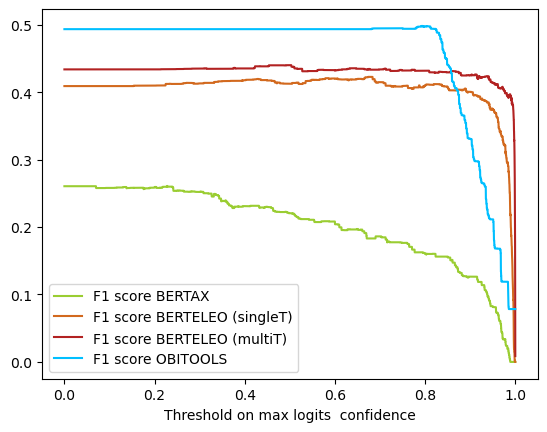

In [3]:


bertax = r'RESULTS\prediction\GeneraSplit_medium_300\bertax_predictions.pkl'
berteleo_multi = r'RESULTS\prediction\GeneraSplit_medium_300\berteleo_multi_predictions.pkl'
berteleo_single = r'RESULTS\prediction\GeneraSplit_medium_300\berteleo_single_predictions.pkl'
obitools = r'RESULTS\prediction\GeneraSplit_medium_300\obitoolsfull_predictions.csv'


f1_scores = []
thresholds = np.arange(0, 1, 0.01)  # Set the range of confidence thresholds
# thresholds = [0.5]




def f1_score(y_true, y_pred_logit,conf = [],thresholds=np.arange(0, 1, 0.0001)):
    if len(conf) :
        y_confidence = conf
        y_pred = y_pred_logit
    else : 
        y_pred = np.argmax(y_pred_logit, axis=1)
        y_confidence = np.max(y_pred_logit, axis=1)
    classes = np.unique(np.concatenate((y_true, y_pred)))
    f1_scores = []
    TP = {cls: 0 for cls in classes}
    FP = {cls: 0 for cls in classes}
    FN = {cls: 0 for cls in classes}
    for threshold in thresholds:
        y_pred_thresholded = np.where(y_confidence >= threshold, y_pred, -1)
        TP = {cls: 0 for cls in classes}
        FP = {cls: 0 for cls in classes}
        FN = {cls: 0 for cls in classes}
        for true_label, pred_label in zip(y_true, y_pred_thresholded):
            if pred_label == -1:
                FN[true_label] += 1
            else:
                if true_label == pred_label:
                    TP[true_label] += 1
                else:
                    FP[pred_label] += 1
                    FN[true_label] += 1
        precision = [TP[cls] / (TP[cls] + FP[cls]) if TP[cls] + FP[cls]> 0 else 0 for cls in classes]
        recall = [TP[cls] / (TP[cls] + FN[cls]) if TP[cls] + FN[cls] > 0 else 0 for cls in classes]
        f1_score = [2 * (precision[cls] * recall[cls]) / (precision[cls] + recall[cls]) if precision[cls] + recall[cls] > 0 else 0 for cls in range(len(precision))]
        macro_f1 = np.mean(f1_score)
        f1_scores.append(macro_f1)
    return thresholds,f1_scores



predicted = pickle.load(open(bertax, 'rb'))
y_true_logit, y_pred_logit = predicted["data"]
y_true_logit = np.array(y_true_logit[1])
y_pred_logit = np.array(y_pred_logit[1])
y_true = np.argmax(y_true_logit, axis=1)
x,y = f1_score(y_true, y_pred_logit)
plt.axes().set_xlabel('Threshold on max logits  confidence')
plt.plot(x,y, label='F1 score BERTAX', color='yellowgreen')





predicted = pickle.load(open(berteleo_single, 'rb'))
y_true = np.array(predicted['labels'])
y_pred_logit =torch.softmax(torch.tensor(predicted['preds'][0]), dim=-1).numpy()
y_pred = np.argmax(predicted['preds'][0], axis=1)
classes = np.unique(np.concatenate((y_true, y_pred)))
x,y = f1_score(y_true, y_pred_logit)
plt.plot(x,y, label='F1 score BERTELEO (singleT)', color='chocolate')



predicted = pickle.load(open(berteleo_multi, 'rb'))

y_true = np.array(predicted['labels'][:,1])
y_pred_logit =torch.softmax(torch.tensor(predicted['preds'][1]), dim=-1).numpy()
y_pred = np.argmax(predicted['preds'][1], axis=1)
classes = np.unique(np.concatenate((y_true, y_pred)))
x,y = f1_score(y_true, y_pred_logit)
plt.plot(x,y, label='F1 score BERTELEO (multiT)', color='firebrick')



predicted = pd.read_csv(obitools)

y_true = predicted['predicted'].to_numpy()
y_pred = predicted['family'].to_numpy()

classes = np.unique(np.concatenate([y_true, y_pred]))
y_confidence= predicted['similarity'].to_numpy()

x,y = f1_score(y_true, y_pred,conf = y_confidence)
plt.plot(x,y, label='F1 score OBITOOLS', color='deepskyblue')
plt.legend()

# Get metrics

In [4]:
from torch import tensor
from torchmetrics.classification import MulticlassAccuracy

c:\ProgramData\anaconda3\envs\teleo_classif\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
predictoins_csv = [os.path.join('BERTeleo/experiments/fine_tune_taxa/outputs/6_fold_multitaxa_4mer_mlm/checkpoints',f,'predictions.csv') for f in os.listdir('BERTeleo/experiments/fine_tune_taxa/outputs/6_fold_multitaxa_4mer_mlm/checkpoints') if 'fold' in f]
DNAbert_macro_accuracy = []
for p in predictoins_csv:
    predicted = pd.read_csv(p)
    y_true = tensor(predicted['labels_family'].to_numpy())
    y_pred = tensor(predicted['preds_family'].to_numpy())

    classes = np.unique(np.concatenate([y_true, y_pred]))
    accuracy = MulticlassAccuracy(num_classes=len(classes),average='macro')

    DNAbert_macro_accuracy.append(accuracy(y_pred,y_true).numpy())


print(np.mean(DNAbert_macro_accuracy))


0.44091702


In [9]:
predictoins_csv = [os.path.join('BERTeleo/experiments/barcodebert/outputs/6_fold_single_barcodebert/checkpoints',f,'predictions.csv') for f in os.listdir('BERTeleo/experiments/fine_tune_taxa/outputs/6_fold_multitaxa_4mer_mlm/checkpoints') if 'fold' in f]
DNAbert_macro_accuracy = []
for p in predictoins_csv:
    predicted = pd.read_csv(p)
    y_true = tensor(predicted['labels_family'].to_numpy())
    y_pred = tensor(predicted['preds_family'].to_numpy())

    classes = np.unique(np.concatenate([y_true, y_pred]))
    accuracy = MulticlassAccuracy(num_classes=len(classes),average='macro')

    DNAbert_macro_accuracy.append(accuracy(y_pred,y_true).numpy())

print(DNAbert_macro_accuracy)
print(np.mean(DNAbert_macro_accuracy))

[array(0.4366811, dtype=float32), array(0.4542961, dtype=float32), array(0.4729256, dtype=float32), array(0.47156098, dtype=float32), array(0.4876272, dtype=float32), array(0.45448816, dtype=float32)]
0.46292987
